In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

/home/alex/miniconda3/envs/mmlatch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read test masks

In [2]:
def read_stored_data(stored_folder):
    audio_masks, text_masks, visual_masks, preds, targets = [], [], [], [], []
    for i in range(1, 23):
        visual_masks.append(torch.load(f"{stored_folder}/masks/mask_visual_batch_{i}.pt").cpu().numpy())
        audio_masks.append(torch.load(f"{stored_folder}/masks/mask_audio_batch_{i}.pt").cpu().numpy())
        text_masks.append(torch.load(f"{stored_folder}/masks/mask_text_batch_{i}.pt").cpu().numpy())
        preds.append(torch.load(f"{stored_folder}/preds/batch_{i}.pt").cpu().numpy())
        targets.append(torch.load(f"{stored_folder}/labels/batch_{i}.pt").cpu().numpy())

    return audio_masks, text_masks, visual_masks, preds, targets

def get_unique_ordered_samples(batches):
    unique_samples = []
    for batch in batches:
        for sample in batch:
            unique_samples.append(sample)
    return unique_samples

def group_masks(au_masks: list, txt_masks: list, vis_masks: list, group_keys: np.array):
    grouped_dict = {}
    keys = list(np.unique(group_keys))
    txt_mask_dict = {int(key): [] for key in keys}
    vis_mask_dict = {int(key): [] for key in keys}
    au_mask_dict = {int(key): [] for key in keys}
    for i in range(group_keys.shape[0]):
        au_mask_dict[int(group_keys[i])].append(au_masks[i])
        vis_mask_dict[int(group_keys[i])].append(vis_masks[i])
        txt_mask_dict[int(group_keys[i])].append(txt_masks[i])

    grouped_dict["text"] = txt_mask_dict
    grouped_dict["visual"] = vis_mask_dict
    grouped_dict["audio"] = au_mask_dict
    return grouped_dict

def collapse_over_time(class_to_mask_dict: dict[int: list]):
    collpsed_dict = {cls: [] for cls in class_to_mask_dict.keys()}
    for cls, masks in class_to_mask_dict.items():
        for mask in masks:
            collpsed_dict[cls].append(np.mean(mask, axis=0))
    return collpsed_dict

def plot_collapsed_per_class(all_target_to_mask_dict):
    for modality, cls_to_mask_dict in all_target_to_mask_dict.items():
        for cls, masks in cls_to_mask_dict.items():
            plt.figure(figsize=(12, 8))
            plt.imshow(np.vstack(masks), aspect='auto', cmap='viridis')
            plt.colorbar(label='Feedback Mask Activation')
            plt.xlabel('Features')
            plt.ylabel('Samples')
            plt.title(f'{modality} Feature Saliency Heatmap (Class {cls})')
            plt.show()


Read the masks (audio, text, visual), the predictions and the targets.

Group the mask per modality and per unique pred or target.

In [3]:
audio_masks, text_masks, visual_masks, preds, targets = read_stored_data(stored_folder="../ablation_study/base")
print(len(audio_masks), len(visual_masks), len(text_masks), len(preds), len(targets))

audio_masks = get_unique_ordered_samples(audio_masks)
text_masks = get_unique_ordered_samples(text_masks)
visual_masks = get_unique_ordered_samples(visual_masks)

preds = [item for arr in preds for item in arr]
targets = [item for arr in targets for item in arr]

test_preds_a7 = np.round(np.clip(np.array(preds), a_min=-3.0, a_max=3.0))
test_truth_a7 = np.round(np.clip(np.array(targets), a_min=-3.0, a_max=3.0))
test_preds_a5 = np.round(np.clip(np.array(preds), a_min=-2.0, a_max=2.0))
test_truth_a5 = np.round(np.clip(np.array(targets), a_min=-2.0, a_max=2.0))

print(len(audio_masks), len(visual_masks), len(text_masks), len(test_preds_a7), len(test_truth_a7), len(test_preds_a5), len(test_truth_a5))

a7_target_to_mask = group_masks(au_masks=audio_masks, txt_masks=text_masks, vis_masks=visual_masks, group_keys=test_truth_a7)

22 22 22 22 22
686 686 686 686 686 686 686


In [4]:
# dict["modality"]["class"] -> lista apo tis maskes (modality = {text, audio, visual}, class = [-2, 2, 1] i [-3, 3, 1])
a7_target_to_mask = group_masks(au_masks=audio_masks, txt_masks=text_masks, vis_masks=visual_masks, group_keys=test_truth_a7)

In [5]:
a7_target_to_mask["text"][0][0].__class__, a7_target_to_mask["text"][0][31].shape, a7_target_to_mask["text"][0][51].shape

(numpy.ndarray, (122, 300), (43, 300))

In [6]:
a7_target_to_mask["text"] = collapse_over_time(a7_target_to_mask["text"])
a7_target_to_mask["visual"] = collapse_over_time(a7_target_to_mask["visual"])
a7_target_to_mask["audio"] = collapse_over_time(a7_target_to_mask["audio"])
a7_target_to_mask["text"][0][0].__class__, a7_target_to_mask["text"][0][31].shape, a7_target_to_mask["text"][0][51].shape

(numpy.ndarray, (300,), (300,))

In [7]:
len(a7_target_to_mask["text"][0]), len(a7_target_to_mask["text"][1])

(106, 113)

In [8]:
np.vstack(a7_target_to_mask["text"][0]).shape, np.vstack(a7_target_to_mask["visual"][0]).shape, np.vstack(a7_target_to_mask["audio"][0]).shape

((106, 300), (106, 35), (106, 74))

### Saliency Heatmaps over the Feature Dimension for each modality and class.

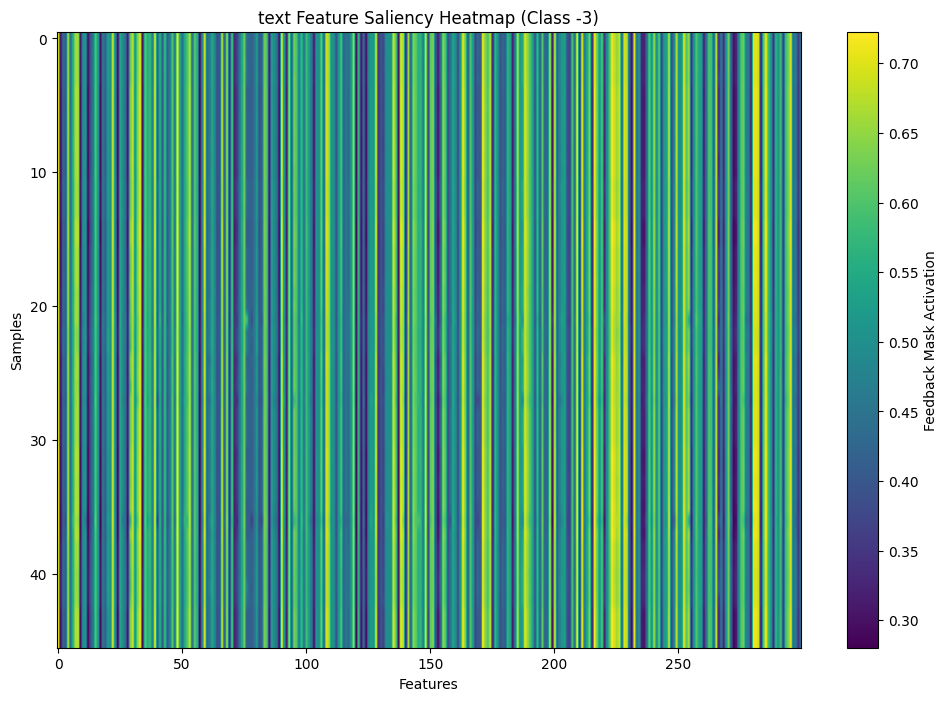

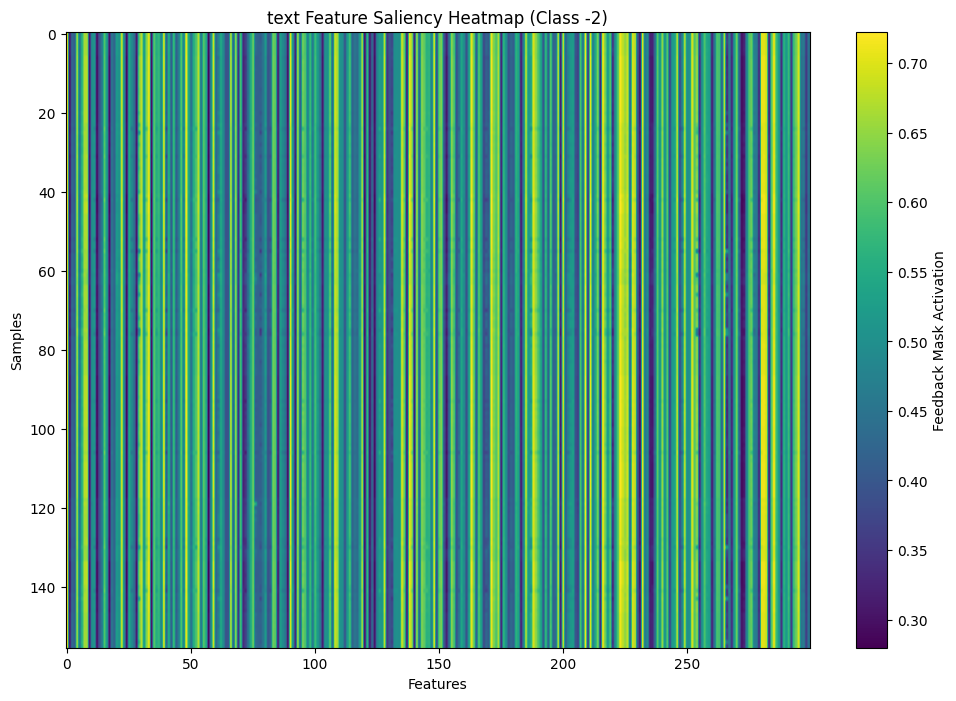

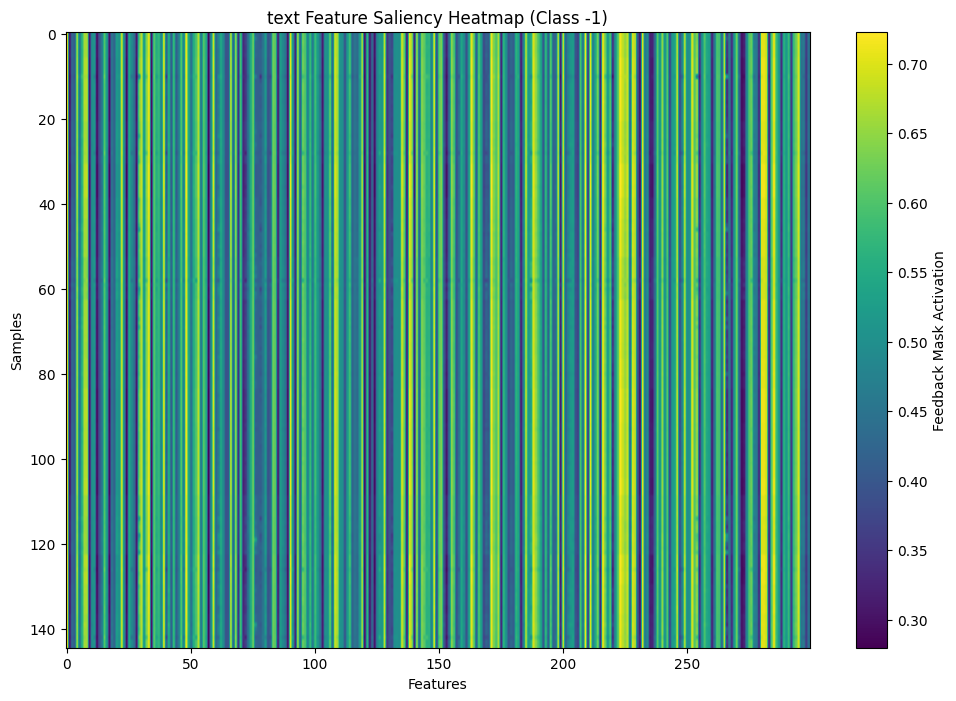

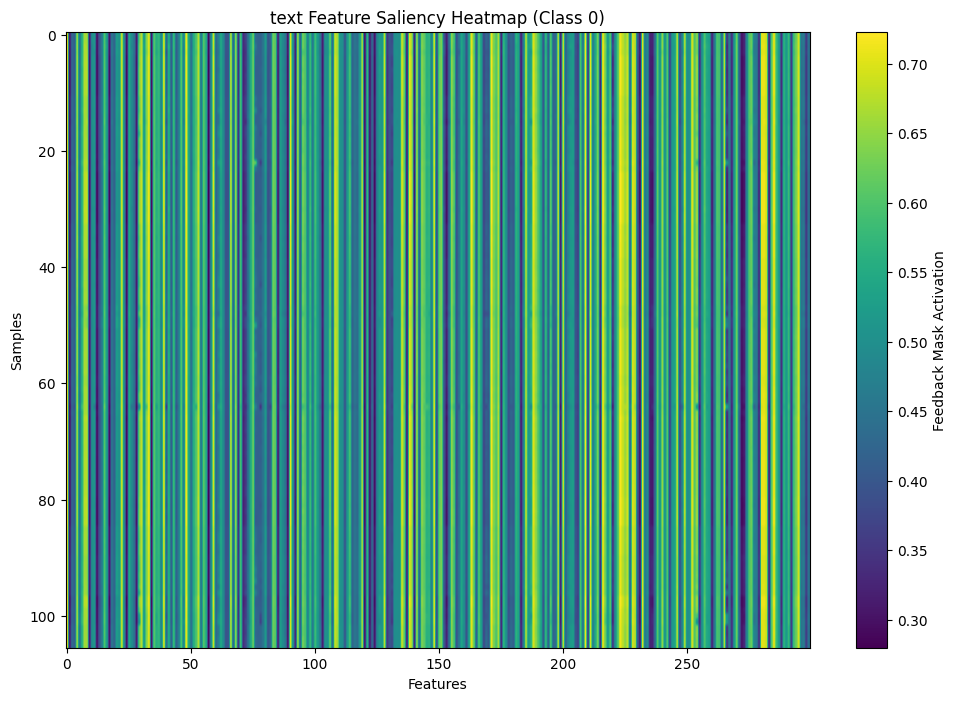

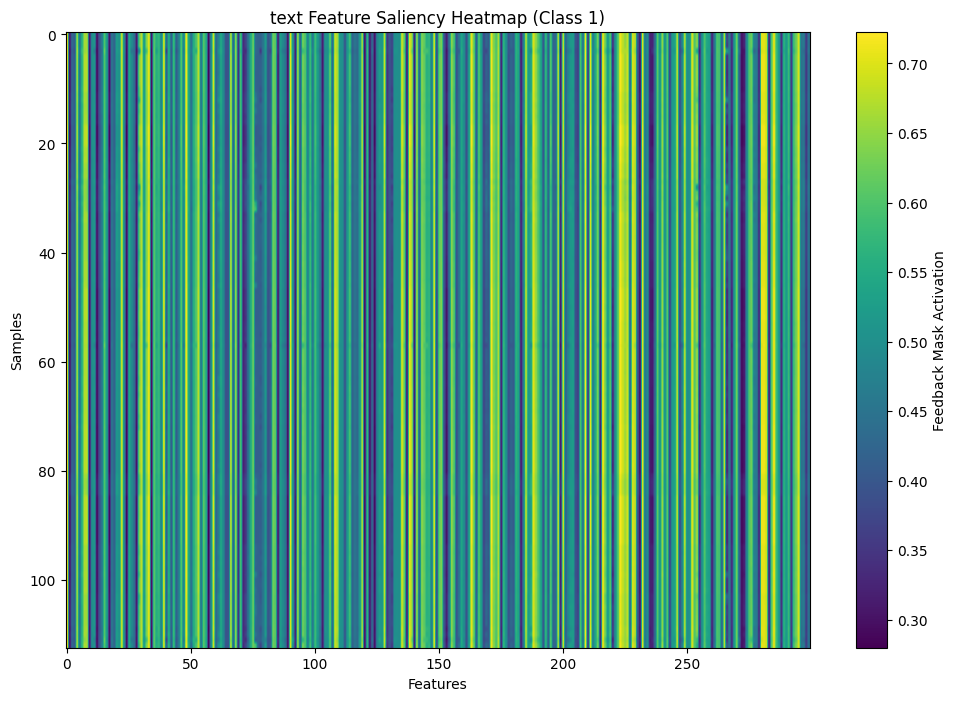

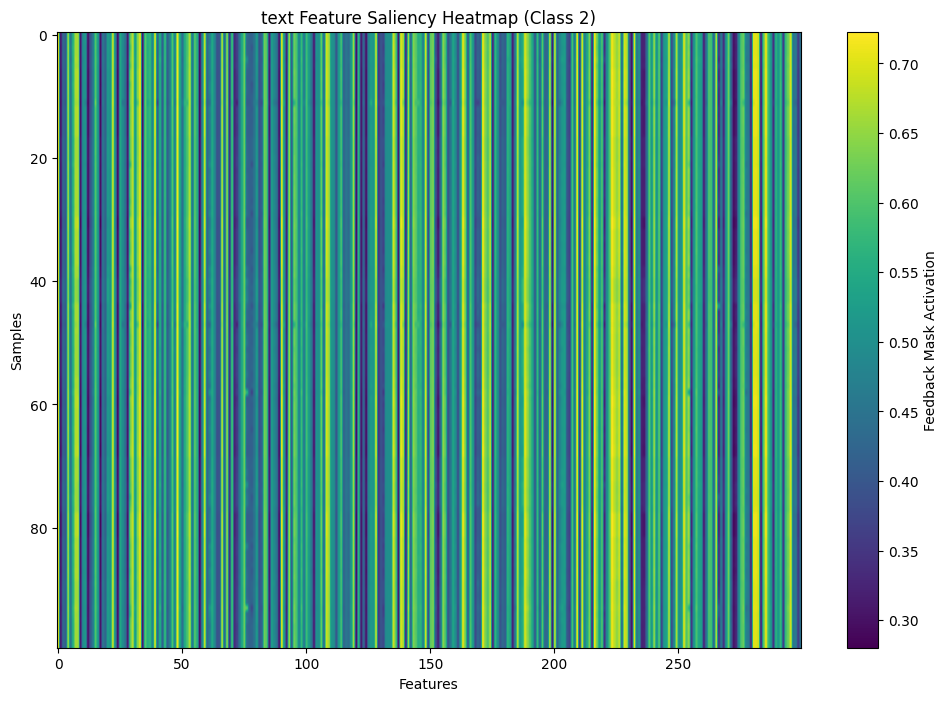

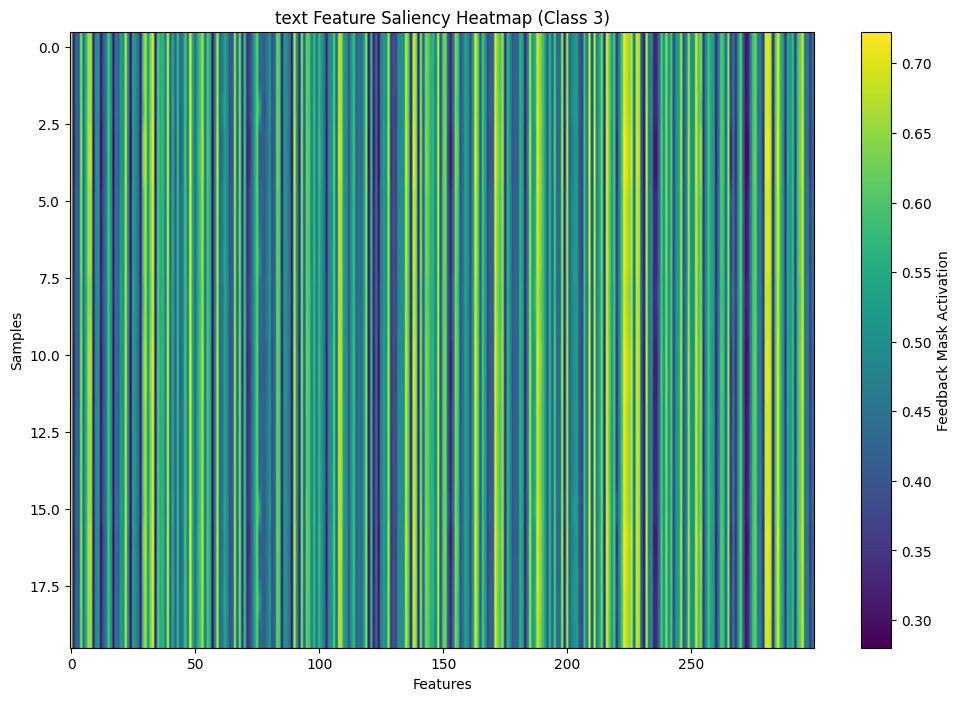

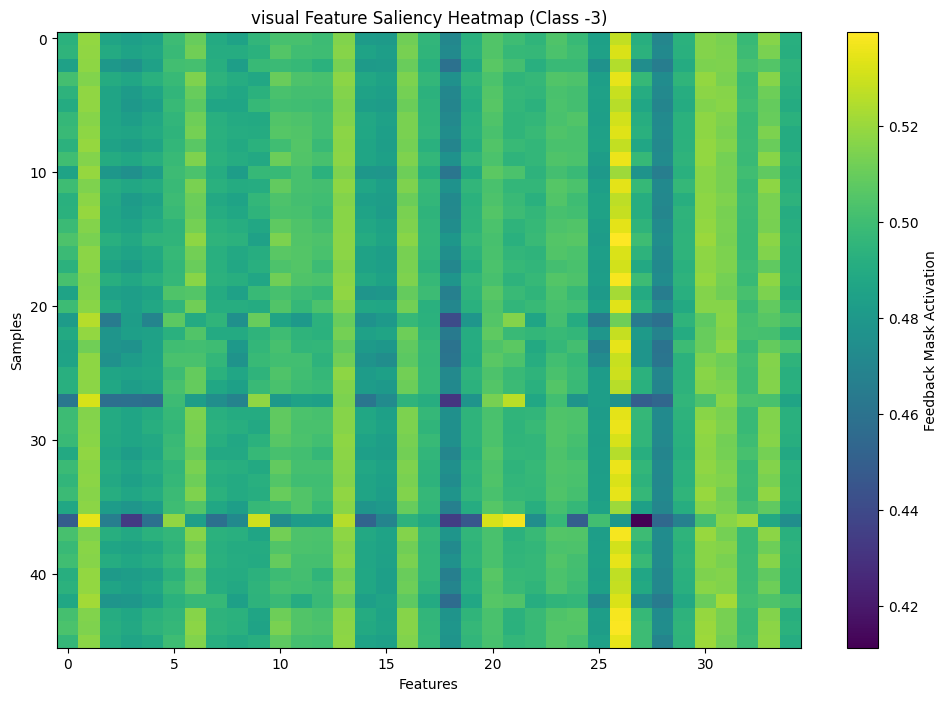

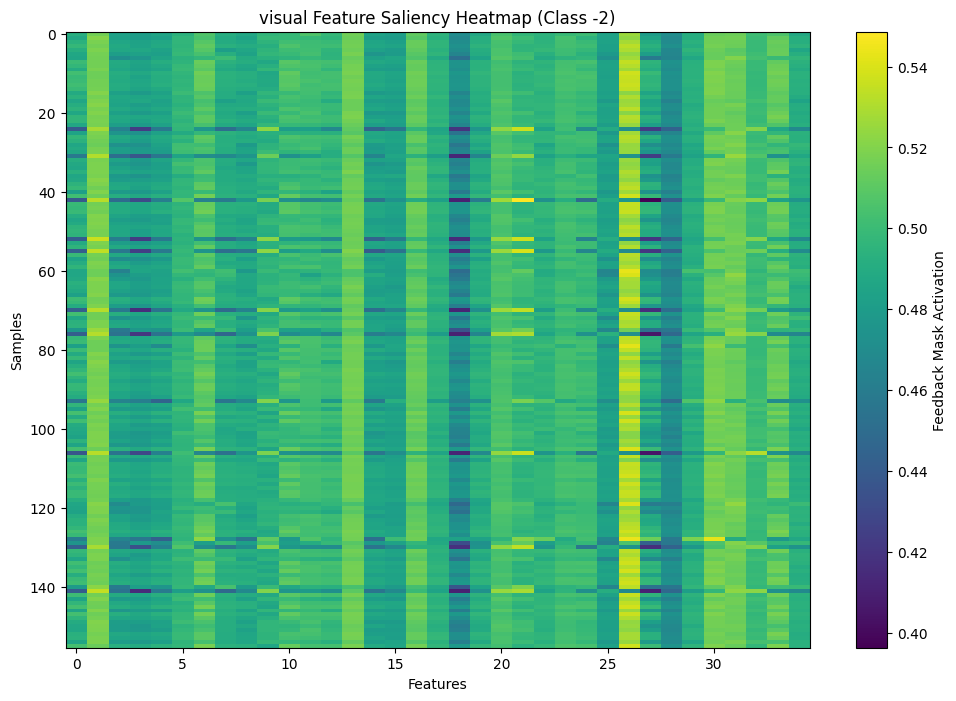

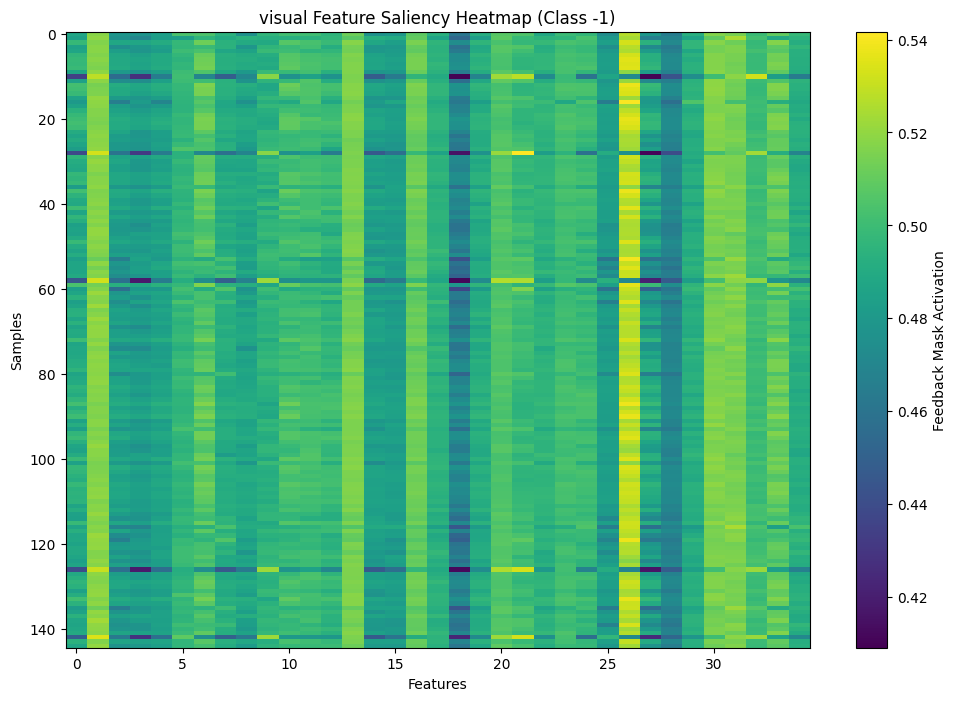

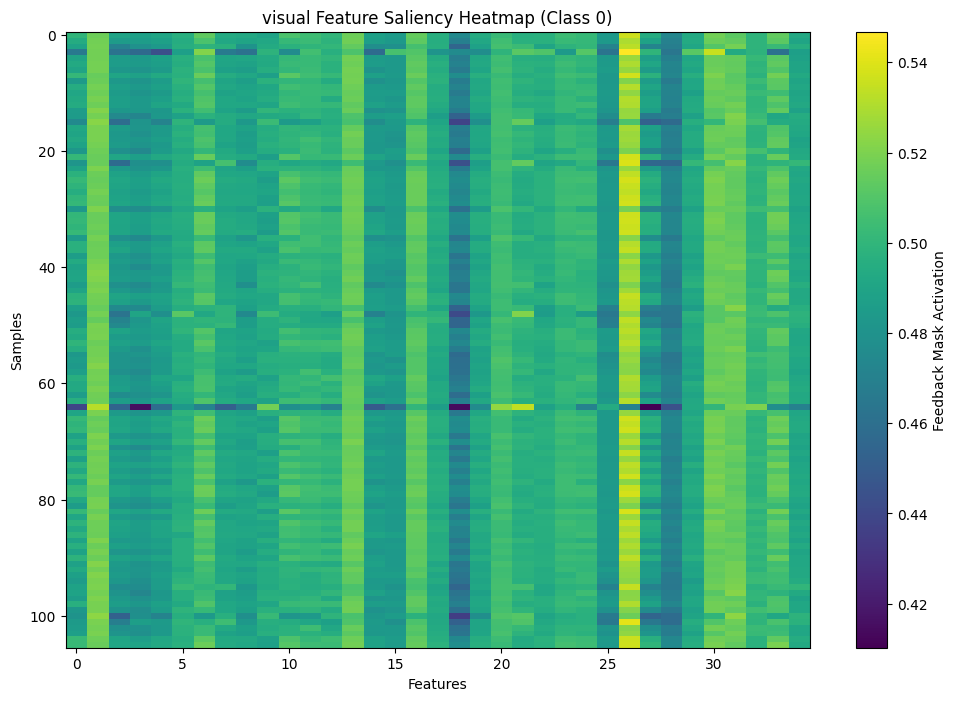

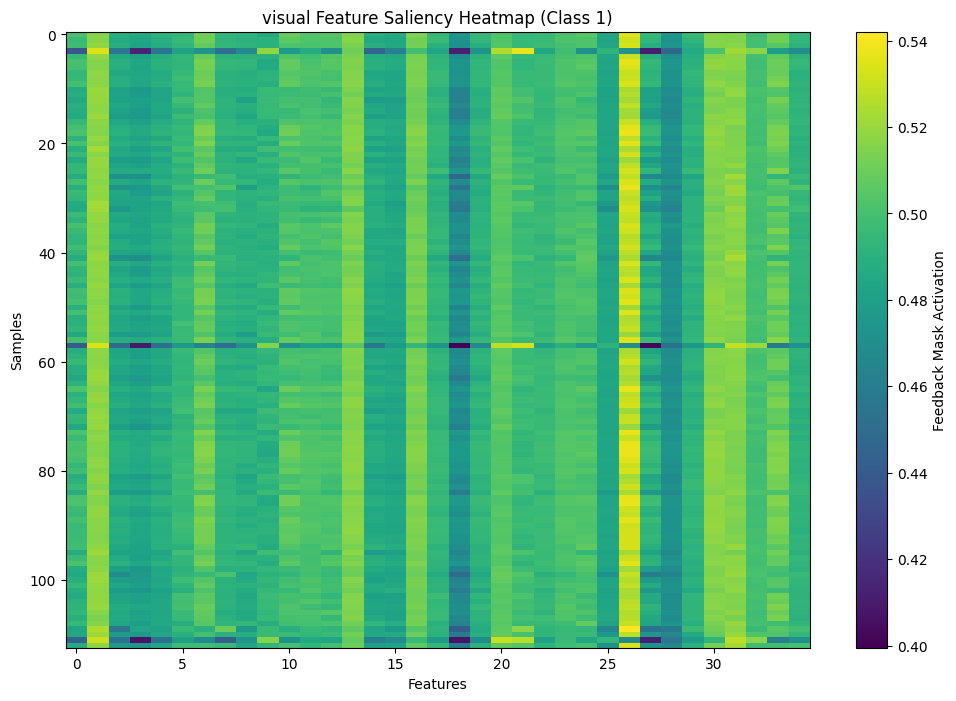

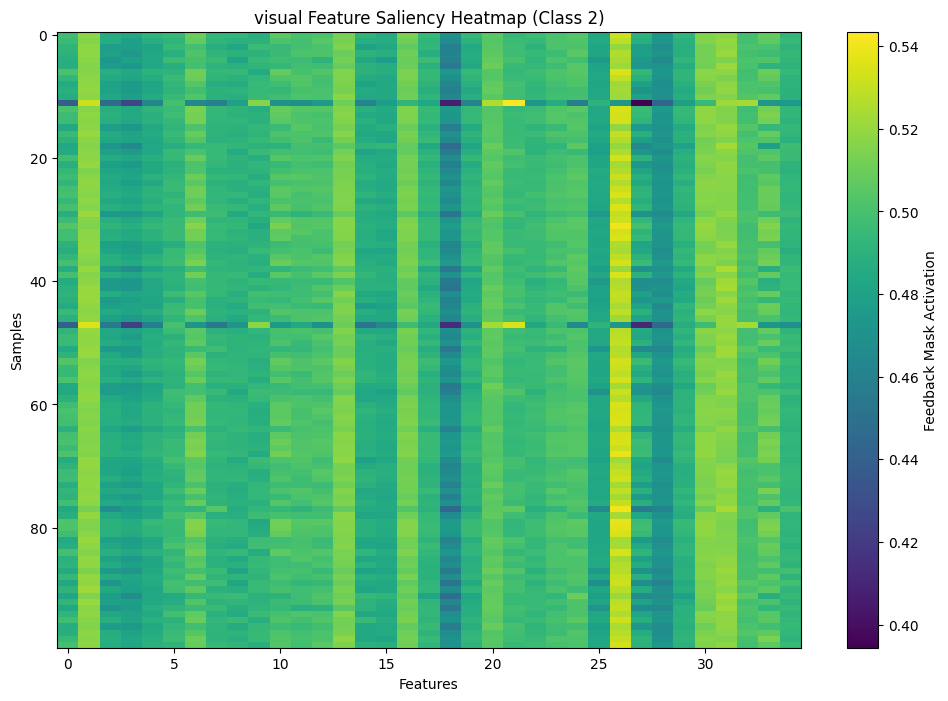

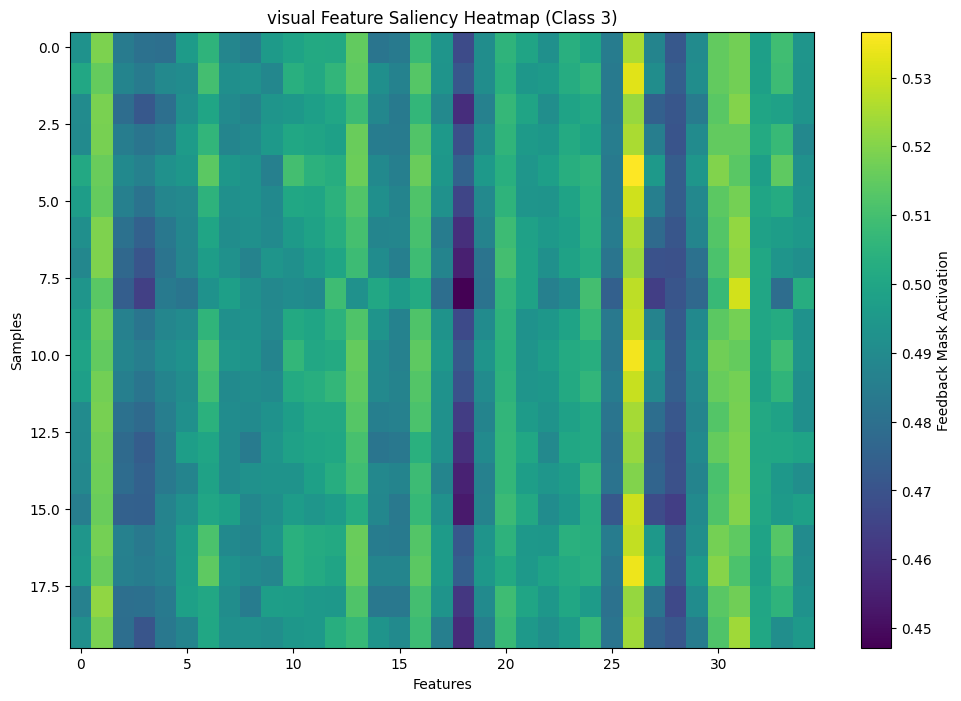

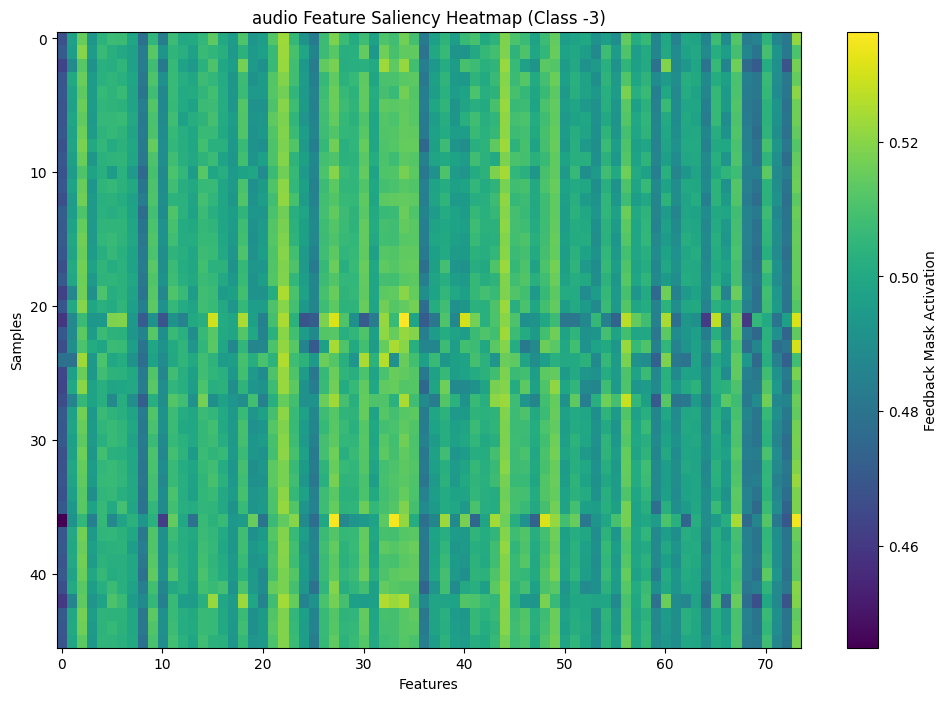

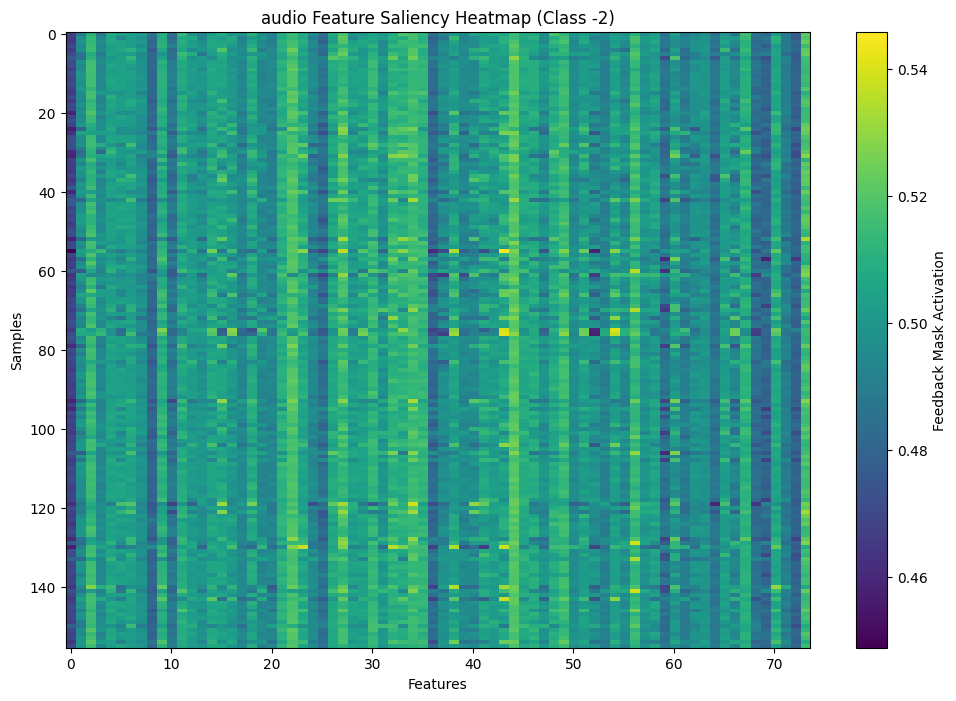

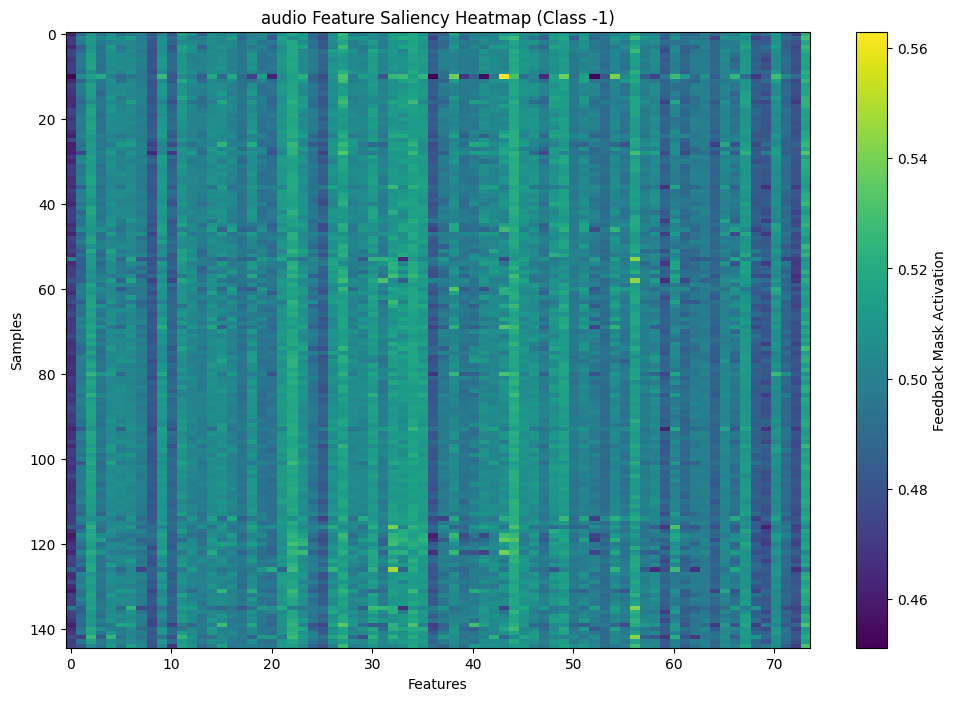

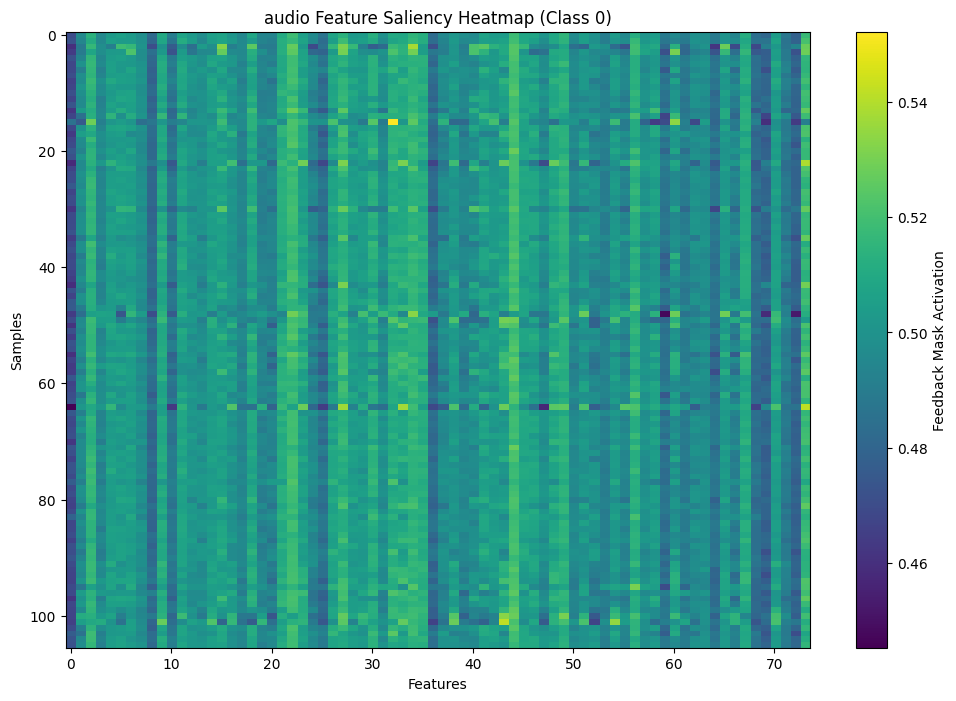

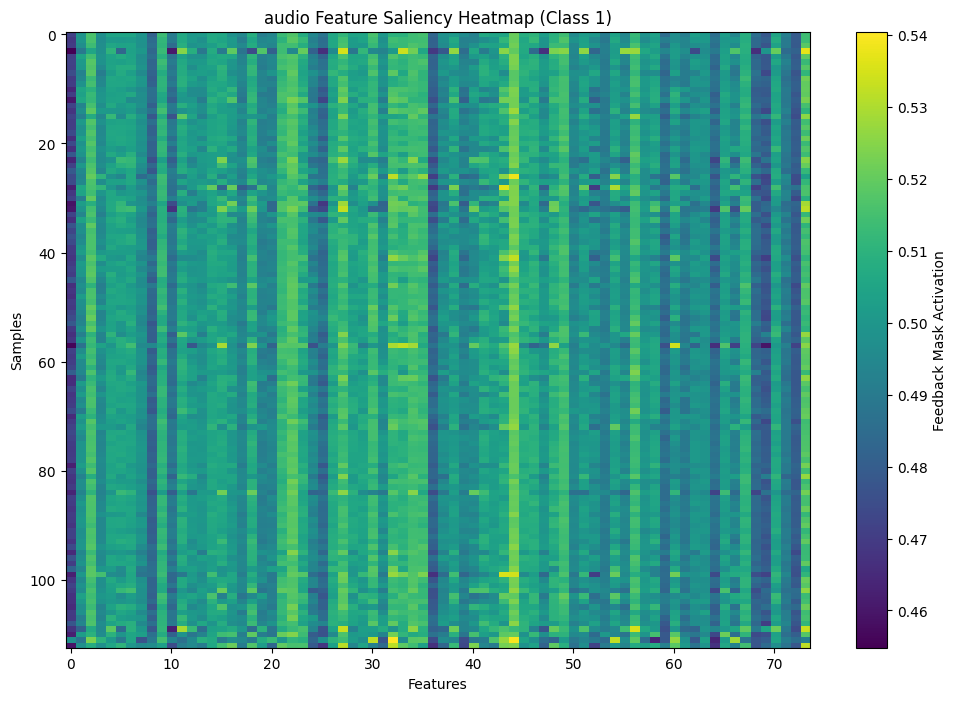

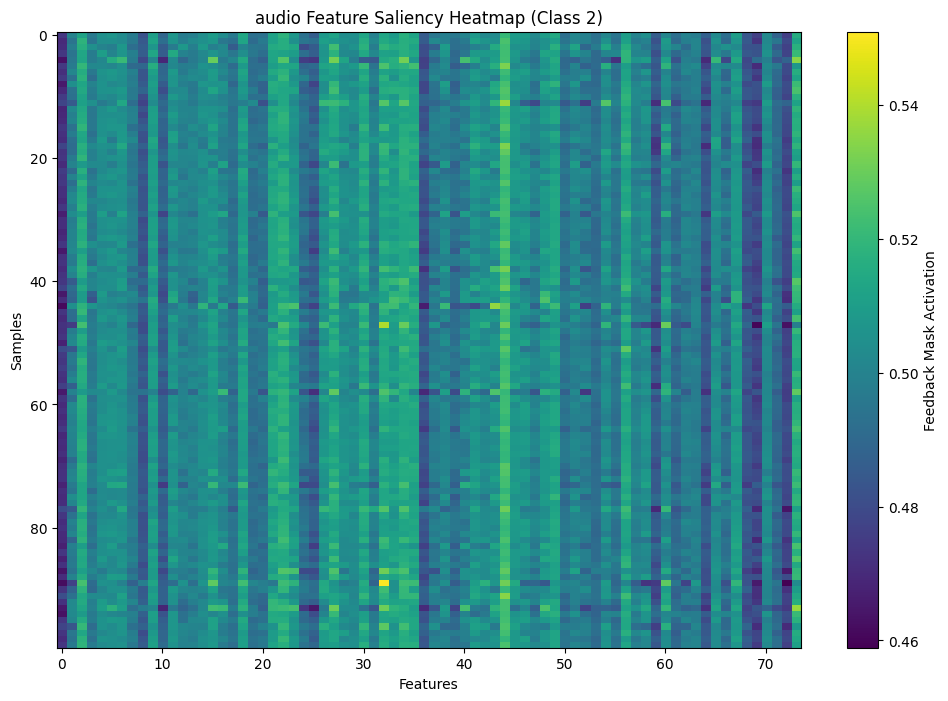

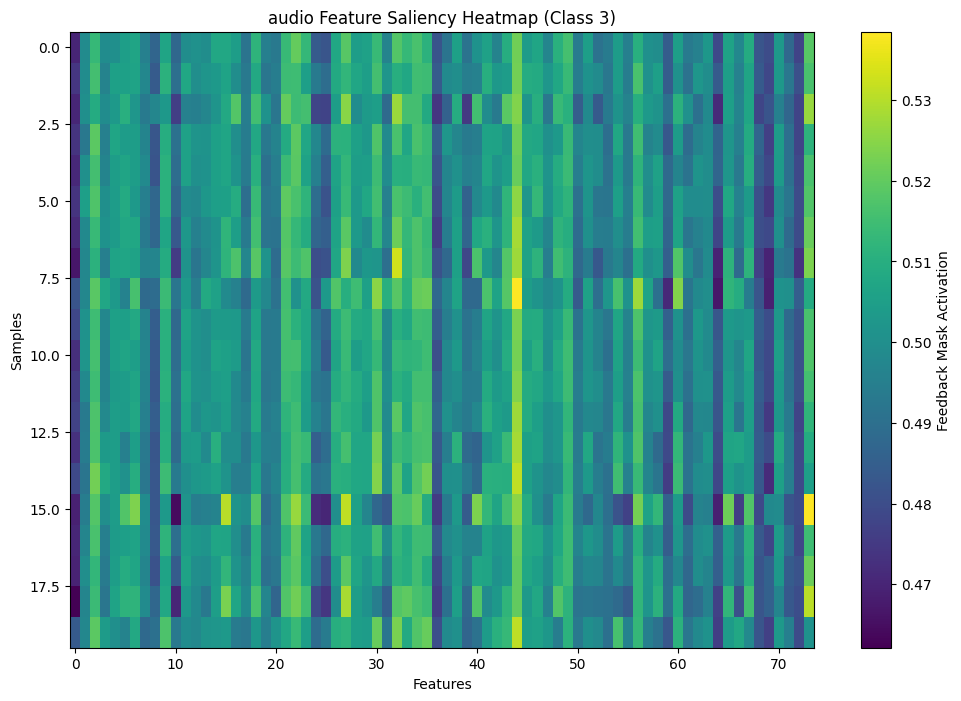

In [9]:
plot_collapsed_per_class(a7_target_to_mask)